# Optimizing Model - Optuna Parameter Optimization for LightGBM

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [3]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_01.csv', sep = ',')

In [4]:
data_flight_info.shape

(578888, 24)

In [5]:
data_weather = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/weather.csv', sep = ',')

In [6]:
data_weather.shape

(14099, 39)

In [7]:
df_flight_info = data_flight_info.copy()
df_weather = data_weather.copy()

In [8]:
#Only want top 19 busiest airports
airports = ['ORD','ATL','DFW','DEN','LAX','CLT','SEA','SFO','EWR','LGA','PHX','IAH','LAS','BOS','MCO','DTW','PHIL','DCA','MSP']
df_flight_info = df_flight_info[df_flight_info['origin'].isin(airports)]
df_flight_info.origin.value_counts()

ATL    59064
ORD    58664
DFW    43987
DEN    41728
CLT    37849
LAX    37708
SEA    29061
PHX    27108
SFO    27099
IAH    26839
DTW    26369
LGA    25168
LAS    25150
MSP    24522
EWR    23629
BOS    22588
DCA    21241
MCO    21114
Name: origin, dtype: int64

In [9]:
df_weather['value'] = df_weather['value'].str.lower()
# create a list of our conditions
conditions = [
    (df_weather['value'].str.contains('sunny')),
    (df_weather['value'].str.contains('cloud')),
    (df_weather['value'].str.contains('mist')),
    (df_weather['value'].str.contains('fog')),
    (df_weather['value'].str.contains('overcast')),
    (df_weather['value'].str.contains('rain')),
    (df_weather['value'].str.contains('drizzle')),
    (df_weather['value'].str.contains('thunder')),
    (df_weather['value'].str.contains('snow')),
    (df_weather['value'].str.contains('sleet')),
    (df_weather['value'].str.contains('blizzard')),
    ]

# create a list of the values we want to assign for each condition
values = ['sunny', 'cloudy', 'cloudy','cloudy','cloudy','rain','rain','rain','snow','snow','snow']

# create a new column and use np.select to assign values to it using our lists as arguments
df_weather['weather_type'] = np.select(conditions, values)
df_weather['weather_type'].value_counts()

sunny     5503
cloudy    4324
rain      2860
snow      1412
Name: weather_type, dtype: int64

In [10]:
df_weather['value'].value_counts().sum()

14099

In [11]:
# Creating year, month, date columns
df_weather['year'] = pd.DatetimeIndex(df_weather['date']).year
df_weather['month'] = pd.DatetimeIndex(df_weather['date']).month
df_weather['day'] = pd.DatetimeIndex(df_weather['date']).day
df_weather['weekday'] = ((pd.DatetimeIndex(df_weather['date']).dayofweek))

#### Merging weather data with flight data

In [12]:
df_weather.rename(columns={'date': 'fl_date', 'airport_code': 'origin'}, inplace=True)

In [13]:
df_flight_info = pd.merge(df_flight_info, df_weather[['fl_date','origin','weather_type']],  how='left', left_on=['fl_date','origin'], right_on = ['fl_date','origin'])


In [14]:
df_flight_info.shape

(632865, 25)

In [15]:
# Dropping the small number of null weather types
df_flight_info = df_flight_info.dropna()

In [16]:
# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [17]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [18]:
# Getting Average Weather Delay
weather_grouped1 = df_flight_info.groupby(by=['origin','month']).mean()
weather_grouped1.reset_index(inplace=True)
weather_grouped1['total_weather_delay'] = weather_grouped1['weather_delay']
weather_grouped1 = weather_grouped1[['origin','total_weather_delay']]

In [19]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]

# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(weather_grouped1, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [20]:
#df_flight_info.isnull().sum()

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [22]:
# encoding df_flight_info 
df_flight_info["weather_type"] = df_flight_info["weather_type"].astype('category').cat.codes
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [23]:
df_flight_info.dtypes

fl_date                  object
mkt_unique_carrier       object
op_unique_carrier        object
op_carrier_fl_num         int64
origin                   object
crs_dep_time              int64
dep_time                float64
dep_delay               float64
dest                     object
arr_time                float64
arr_delay               float64
crs_arr_time              int64
crs_elapsed_time        float64
actual_elapsed_time     float64
distance                float64
carrier_delay           float64
weather_delay           float64
nas_delay               float64
security_delay          float64
late_aircraft_delay     float64
year                      int64
month                     int64
day                       int64
weekday                 float64
weather_type               int8
flight_number             int16
total_security_delay    float64
total_nas_delay         float64
average_route_time      float64
total_dep_delay         float64
total_arr_delay         float64
total_we

### Adding Total Weather Delay

In [24]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','year','month','day','weekday','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay','weather_type','total_weather_delay']]
y = df_flight_info['arr_delay']

In [25]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [39]:

import seaborn as sns
import lightgbm as lgb
import optuna
from optuna._imports import try_import
from optuna.integration import _lightgbm_tuner as lightgbm_tuner


# Convert dataset to type of LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Basic parameters for learning
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
}

# Make Hyperparameters be Stepwise Optimization with Optuna
tuned_booster = lightgbm_tuner.train(lgb_params, lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=50,
                                     early_stopping_rounds=5,
                                     verbose_eval=2,
                                     )

# Also prepare a model with default parameters for comparison
default_booster = lgb.train(lgb_params, lgb_train,
                            valid_sets=lgb_valid,
                            num_boost_round=50,
                            early_stopping_rounds=5,
                            verbose_eval=2,
                            )

# Score for Optuna
y_pred_tuned = tuned_booster.predict(X_test)
tuned_metric = mean_squared_error(y_test, y_pred_tuned)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_tuned))

# Score for default
y_pred_default = default_booster.predict(X_test)
default_metric = mean_squared_error(y_test, y_pred_default)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_default)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_default))



  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2623
[4]	valid_0's rmse: 41.8783
[6]	valid_0's rmse: 41.657
[8]	valid_0's rmse: 41.4342
[10]	valid_0's rmse: 41.3275
[12]	valid_0's rmse: 41.2364
[14]	valid_0's rmse: 41.1179
[16]	valid_0's rmse: 41.0256
[18]	valid_0's rmse: 40.9582
[20]	valid_0's rmse: 40.88
[22]	valid_0's rmse: 40.832
[24]	valid_0's rmse: 40.7817
[26]	valid_0's rmse: 40.748
[28]	valid_0's rmse: 40.7146
[30]	valid_0's rmse: 40.6738
[32]	valid_0's rmse: 40.6486
[34]	valid_0's rmse: 40.604
[36]	valid_0's rmse: 40.5611
[38]	valid_0's rm



feature_fraction, val_score: 40.410818:   0%|          | 0/7 [00:25<?, ?it/s]

feature_fraction, val_score: 40.410818:  14%|#4        | 1/7 [00:25<02:33, 25.55s/it]

feature_fraction, val_score: 40.410818:  14%|#4        | 1/7 [00:25<02:33, 25.55s/it]

[50]	valid_0's rmse: 40.4108
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.4108
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2275
[4]	valid_0's rmse: 41.8302
[6]	valid_0's rmse: 41.597
[8]	valid_0's rmse: 41.3631
[10]	valid_0's rmse: 41.1989
[12]	valid_0's rmse: 41.0859
[14]	valid_0's rmse: 40.9828
[16]	valid_0's rmse: 40.9073
[18]	valid_0's rmse: 40.8392
[20]	valid_0's rmse: 40.7845
[22]	valid_0's rmse: 40.7384
[24]	valid_0's rmse: 40.6981
[26]	valid_0's rmse: 40.6575
[28]	valid_0's rmse: 40.6252
[30]	valid_0's rmse: 4



feature_fraction, val_score: 40.262837:  14%|#4        | 1/7 [00:49<02:33, 25.55s/it]

feature_fraction, val_score: 40.262837:  29%|##8       | 2/7 [00:49<02:04, 24.89s/it]

feature_fraction, val_score: 40.262837:  29%|##8       | 2/7 [00:50<02:04, 24.89s/it]

[50]	valid_0's rmse: 40.2628
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.2628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.761321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2412
[4]	valid_0's rmse: 41.848
[6]	valid_0's rmse: 41.6254
[8]	valid_0's rmse: 41.395
[10]	valid_0's rmse: 41.2761
[12]	valid_0's rmse: 41.1913
[14]	valid_0's rmse: 41.0771
[16]	valid_0's rmse: 40.987
[18]	valid_0's rmse: 40.9043
[20]	valid_0's rmse: 40.8387
[22]	valid_0's rmse: 40.7945
[24]	valid_0's rmse: 40.7508
[26]	valid_0's rmse: 40.7117
[28]	valid_0's rmse: 40.6866
[30]	valid_0's rmse: 40.643
[32]	valid_0's rmse: 40.6079
[34]	valid_0's rmse: 40.5596
[3



feature_fraction, val_score: 40.262837:  29%|##8       | 2/7 [01:20<02:04, 24.89s/it]

feature_fraction, val_score: 40.262837:  43%|####2     | 3/7 [01:20<01:49, 27.47s/it]

feature_fraction, val_score: 40.262837:  43%|####2     | 3/7 [01:20<01:49, 27.47s/it]

[50]	valid_0's rmse: 40.3506
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.3506
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2273
[4]	valid_0's rmse: 41.8257
[6]	valid_0's rmse: 41.5943
[8]	valid_0's rmse: 41.3651
[10]	valid_0's rmse: 41.1957
[12]	valid_0's rmse: 41.0871
[14]	valid_0's rmse: 40.9808
[16]	valid_0's rmse: 40.9016
[18]	valid_0's rmse: 40.8336
[20]	valid_0's rmse: 40.7728
[22]	valid_0's rmse: 40.728
[24]	valid_0's rmse: 40.6899
[26]	valid_0's rmse: 40.6451
[28]	valid_0's rmse: 40.6161
[30]	valid_0's rmse: 4



feature_fraction, val_score: 40.239929:  43%|####2     | 3/7 [01:46<01:49, 27.47s/it]

feature_fraction, val_score: 40.239929:  57%|#####7    | 4/7 [01:46<01:20, 26.99s/it]

feature_fraction, val_score: 40.239929:  57%|#####7    | 4/7 [01:46<01:20, 26.99s/it]

[50]	valid_0's rmse: 40.2399
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.2399
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2246
[4]	valid_0's rmse: 41.8103
[6]	valid_0's rmse: 41.5185
[8]	valid_0's rmse: 41.3055
[10]	valid_0's rmse: 41.147
[12]	valid_0's rmse: 41.033
[14]	valid_0's rmse: 40.9432
[16]	valid_0's rmse: 40.8766
[18]	valid_0's rmse: 40.8228
[20]	valid_0's rmse: 40.774
[22]	valid_0's rmse: 40.717
[24]	valid_0's rmse: 40.6715
[26]	valid_0's rmse: 40.6267
[28]	valid_0's rmse: 40.5937
[30]	valid_0's rmse: 40.5



feature_fraction, val_score: 40.225051:  57%|#####7    | 4/7 [02:11<01:20, 26.99s/it]

feature_fraction, val_score: 40.225051:  71%|#######1  | 5/7 [02:11<00:52, 26.24s/it]

feature_fraction, val_score: 40.225051:  71%|#######1  | 5/7 [02:11<00:52, 26.24s/it]

[50]	valid_0's rmse: 40.2251
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.2251
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2265
[4]	valid_0's rmse: 41.8088
[6]	valid_0's rmse: 41.5134
[8]	valid_0's rmse: 41.3101
[10]	valid_0's rmse: 41.1553
[12]	valid_0's rmse: 41.0352
[14]	valid_0's rmse: 40.9528
[16]	valid_0's rmse: 40.8785
[18]	valid_0's rmse: 40.8146
[20]	valid_0's rmse: 40.7604
[22]	valid_0's rmse: 40.7159
[24]	valid_0's rmse: 40.6683
[26]	valid_0's rmse: 40.6175
[28]	valid_0's rmse: 40.5803
[30]	valid_0's rmse: 



feature_fraction, val_score: 40.214245:  71%|#######1  | 5/7 [02:39<00:52, 26.24s/it]

feature_fraction, val_score: 40.214245:  86%|########5 | 6/7 [02:39<00:26, 26.69s/it]

feature_fraction, val_score: 40.214245:  86%|########5 | 6/7 [02:39<00:26, 26.69s/it]

[50]	valid_0's rmse: 40.2142
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.2142
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2416
[4]	valid_0's rmse: 41.8482
[6]	valid_0's rmse: 41.6276
[8]	valid_0's rmse: 41.3926
[10]	valid_0's rmse: 41.2307
[12]	valid_0's rmse: 41.1349
[14]	valid_0's rmse: 41.0303
[16]	valid_0's rmse: 40.9402
[18]	valid_0's rmse: 40.8614
[20]	valid_0's rmse: 40.8001
[22]	valid_0's rmse: 40.7582
[24]	valid_0's rmse: 40.715
[26]	valid_0's rmse: 40.6765
[28]	valid_0's rmse: 40.6455
[30]	valid_0's rmse: 4



feature_fraction, val_score: 40.214245:  86%|########5 | 6/7 [03:03<00:26, 26.69s/it]

feature_fraction, val_score: 40.214245: 100%|##########| 7/7 [03:03<00:00, 26.20s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 40.214245:   0%|          | 0/20 [00:00<?, ?it/s]

[50]	valid_0's rmse: 40.2999
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.2999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0132
[4]	valid_0's rmse: 41.3882
[6]	valid_0's rmse: 40.9473
[8]	valid_0's rmse: 40.5999
[10]	valid_0's rmse: 40.3227
[12]	valid_0's rmse: 40.0935
[14]	valid_0's rmse: 39.9144
[16]	valid_0's rmse: 39.7449
[18]	valid_0's rmse: 39.5673
[20]	valid_0's rmse: 39.412
[22]	valid_0's rmse: 39.2893
[24]	valid_0's rmse: 39.1742
[26]	valid_0's rmse: 39.0375
[28]	valid_0's rmse: 38.9336
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.696592:   0%|          | 0/20 [00:33<?, ?it/s]

num_leaves, val_score: 37.696592:   5%|5         | 1/20 [00:33<10:35, 33.44s/it]

num_leaves, val_score: 37.696592:   5%|5         | 1/20 [00:33<10:35, 33.44s/it]

[50]	valid_0's rmse: 37.6966
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.6966
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.075
[4]	valid_0's rmse: 41.5258
[6]	valid_0's rmse: 41.1185
[8]	valid_0's rmse: 40.815
[10]	valid_0's rmse: 40.5853
[12]	valid_0's rmse: 40.3876
[14]	valid_0's rmse: 40.2355
[16]	valid_0's rmse: 40.0948
[18]	valid_0's rmse: 39.9643
[20]	valid_0's rmse: 39.8543
[22]	valid_0's rmse: 39.7503
[24]	valid_0's rmse: 39.6654
[26]	valid_0's rmse: 39.5808
[28]	valid_0's rmse: 39.498
[30]	valid_0's rmse: 39.



num_leaves, val_score: 37.696592:   5%|5         | 1/20 [01:07<10:35, 33.44s/it]

num_leaves, val_score: 37.696592:  10%|#         | 2/20 [01:07<10:03, 33.54s/it]

num_leaves, val_score: 37.696592:  10%|#         | 2/20 [01:07<10:03, 33.54s/it]

[50]	valid_0's rmse: 38.5397
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.5397
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1727
[4]	valid_0's rmse: 41.7134
[6]	valid_0's rmse: 41.3867
[8]	valid_0's rmse: 41.1587
[10]	valid_0's rmse: 40.9752
[12]	valid_0's rmse: 40.8434
[14]	valid_0's rmse: 40.737
[16]	valid_0's rmse: 40.6497
[18]	valid_0's rmse: 40.5712
[20]	valid_0's rmse: 40.5063
[22]	valid_0's rmse: 40.4434
[24]	valid_0's rmse: 40.385
[26]	valid_0's rmse: 40.3279
[28]	valid_0's rmse: 40.2823
[30]	valid_0's rmse: 40



num_leaves, val_score: 37.696592:  10%|#         | 2/20 [01:35<10:03, 33.54s/it]

num_leaves, val_score: 37.696592:  15%|#5        | 3/20 [01:35<08:50, 31.20s/it]

num_leaves, val_score: 37.696592:  15%|#5        | 3/20 [01:35<08:50, 31.20s/it]

[50]	valid_0's rmse: 39.7685
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.7685
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1282
[4]	valid_0's rmse: 41.6258
[6]	valid_0's rmse: 41.2609
[8]	valid_0's rmse: 41.0067
[10]	valid_0's rmse: 40.8035
[12]	valid_0's rmse: 40.6502
[14]	valid_0's rmse: 40.5226
[16]	valid_0's rmse: 40.4087
[18]	valid_0's rmse: 40.3146
[20]	valid_0's rmse: 40.226
[22]	valid_0's rmse: 40.1519
[24]	valid_0's rmse: 40.0885
[26]	valid_0's rmse: 40.0129
[28]	valid_0's rmse: 39.9461
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.696592:  15%|#5        | 3/20 [02:05<08:50, 31.20s/it]

num_leaves, val_score: 37.696592:  20%|##        | 4/20 [02:05<08:14, 30.89s/it]

num_leaves, val_score: 37.696592:  20%|##        | 4/20 [02:05<08:14, 30.89s/it]

[50]	valid_0's rmse: 39.2547
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.2547
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1988
[4]	valid_0's rmse: 41.7629
[6]	valid_0's rmse: 41.4556
[8]	valid_0's rmse: 41.234
[10]	valid_0's rmse: 41.069
[12]	valid_0's rmse: 40.9417
[14]	valid_0's rmse: 40.8382
[16]	valid_0's rmse: 40.7529
[18]	valid_0's rmse: 40.6846
[20]	valid_0's rmse: 40.631
[22]	valid_0's rmse: 40.5663
[24]	valid_0's rmse: 40.5228
[26]	valid_0's rmse: 40.4701
[28]	valid_0's rmse: 40.4279
[30]	valid_0's rmse: 40.



num_leaves, val_score: 37.696592:  20%|##        | 4/20 [02:34<08:14, 30.89s/it]

num_leaves, val_score: 37.696592:  25%|##5       | 5/20 [02:34<07:31, 30.09s/it]

[50]	valid_0's rmse: 39.9945
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.9945




num_leaves, val_score: 37.696592:  25%|##5       | 5/20 [02:34<07:31, 30.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1786
[4]	valid_0's rmse: 41.7221
[6]	valid_0's rmse: 41.3964
[8]	valid_0's rmse: 41.1655
[10]	valid_0's rmse: 40.9888
[12]	valid_0's rmse: 40.8509
[14]	valid_0's rmse: 40.7511
[16]	valid_0's rmse: 40.6567
[18]	valid_0's rmse: 40.5853
[20]	valid_0's rmse: 40.5118
[22]	valid_0's rmse: 40.4499
[24]	valid_0's rmse: 40.3971
[26]	valid_0's rmse: 40.344
[28]	valid_0's rmse: 40.3014
[30]	valid_0's rmse: 40.2562
[32]	valid_0's rmse: 40.1957
[34]	valid_0's rmse: 40.1439
[36]	valid_0's rmse: 40.1043
[38]	valid_0



num_leaves, val_score: 37.696592:  25%|##5       | 5/20 [03:02<07:31, 30.09s/it]

num_leaves, val_score: 37.696592:  30%|###       | 6/20 [03:02<06:50, 29.35s/it]

num_leaves, val_score: 37.696592:  30%|###       | 6/20 [03:02<06:50, 29.35s/it]

[50]	valid_0's rmse: 39.8092
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.8092
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0514
[4]	valid_0's rmse: 41.4822
[6]	valid_0's rmse: 41.0598
[8]	valid_0's rmse: 40.7439
[10]	valid_0's rmse: 40.4835
[12]	valid_0's rmse: 40.2723
[14]	valid_0's rmse: 40.1031
[16]	valid_0's rmse: 39.9468
[18]	valid_0's rmse: 39.7979
[20]	valid_0's rmse: 39.6555
[22]	valid_0's rmse: 39.5473
[24]	valid_0's rmse: 39.4476
[26]	valid_0's rmse: 39.3407
[28]	valid_0's rmse: 39.2402
[30]	valid_0's rmse: 



num_leaves, val_score: 37.696592:  30%|###       | 6/20 [03:33<06:50, 29.35s/it]

num_leaves, val_score: 37.696592:  35%|###5      | 7/20 [03:33<06:29, 29.98s/it]

num_leaves, val_score: 37.696592:  35%|###5      | 7/20 [03:33<06:29, 29.98s/it]

[50]	valid_0's rmse: 38.1851
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.1851
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1665
[4]	valid_0's rmse: 41.7023
[6]	valid_0's rmse: 41.3668
[8]	valid_0's rmse: 41.1303
[10]	valid_0's rmse: 40.9502
[12]	valid_0's rmse: 40.815
[14]	valid_0's rmse: 40.7091
[16]	valid_0's rmse: 40.615
[18]	valid_0's rmse: 40.5276
[20]	valid_0's rmse: 40.4558
[22]	valid_0's rmse: 40.407
[24]	valid_0's rmse: 40.3517
[26]	valid_0's rmse: 40.2893
[28]	valid_0's rmse: 40.249
[30]	valid_0's rmse: 40.2



num_leaves, val_score: 37.696592:  35%|###5      | 7/20 [04:00<06:29, 29.98s/it]

num_leaves, val_score: 37.696592:  40%|####      | 8/20 [04:00<05:48, 29.01s/it]

num_leaves, val_score: 37.696592:  40%|####      | 8/20 [04:00<05:48, 29.01s/it]

[50]	valid_0's rmse: 39.6941
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.6941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.041566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0706
[4]	valid_0's rmse: 41.5129
[6]	valid_0's rmse: 41.1074
[8]	valid_0's rmse: 40.8021
[10]	valid_0's rmse: 40.5665
[12]	valid_0's rmse: 40.3488
[14]	valid_0's rmse: 40.1996
[16]	valid_0's rmse: 40.0597
[18]	valid_0's rmse: 39.9297
[20]	valid_0's rmse: 39.8167
[22]	valid_0's rmse: 39.7181
[24]	valid_0's rmse: 39.6158
[26]	valid_0's rmse: 39.5016
[28]	valid_0's rmse: 39.4232
[30]	valid_0's rmse: 39.321
[32]	valid_0's rmse: 39.2261
[34]	valid_0's rmse: 39.1367



num_leaves, val_score: 37.696592:  40%|####      | 8/20 [04:38<05:48, 29.01s/it]

num_leaves, val_score: 37.696592:  45%|####5     | 9/20 [04:38<05:50, 31.85s/it]

num_leaves, val_score: 37.696592:  45%|####5     | 9/20 [04:38<05:50, 31.85s/it]

[50]	valid_0's rmse: 38.4433
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.4433
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0216
[4]	valid_0's rmse: 41.4022
[6]	valid_0's rmse: 40.9642
[8]	valid_0's rmse: 40.6252
[10]	valid_0's rmse: 40.346
[12]	valid_0's rmse: 40.1355
[14]	valid_0's rmse: 39.9541
[16]	valid_0's rmse: 39.7967
[18]	valid_0's rmse: 39.6296
[20]	valid_0's rmse: 39.4903
[22]	valid_0's rmse: 39.371
[24]	valid_0's rmse: 39.2601
[26]	valid_0's rmse: 39.1283
[28]	valid_0's rmse: 39.0106
[30]	valid_0's rmse: 38



num_leaves, val_score: 37.696592:  45%|####5     | 9/20 [05:12<05:50, 31.85s/it]

num_leaves, val_score: 37.696592:  50%|#####     | 10/20 [05:12<05:25, 32.57s/it]

num_leaves, val_score: 37.696592:  50%|#####     | 10/20 [05:13<05:25, 32.57s/it]

[50]	valid_0's rmse: 37.8462
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.8462
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9915
[4]	valid_0's rmse: 41.3674
[6]	valid_0's rmse: 40.897
[8]	valid_0's rmse: 40.5379
[10]	valid_0's rmse: 40.2539
[12]	valid_0's rmse: 40.0088
[14]	valid_0's rmse: 39.8165
[16]	valid_0's rmse: 39.6367
[18]	valid_0's rmse: 39.4684
[20]	valid_0's rmse: 39.3002
[22]	valid_0's rmse: 39.1741
[24]	valid_0's rmse: 39.0372
[26]	valid_0's rmse: 38.8712
[28]	valid_0's rmse: 38.7488
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.441159:  50%|#####     | 10/20 [05:48<05:25, 32.57s/it]

num_leaves, val_score: 37.441159:  55%|#####5    | 11/20 [05:48<05:01, 33.50s/it]

num_leaves, val_score: 37.441159:  55%|#####5    | 11/20 [05:48<05:01, 33.50s/it]

[50]	valid_0's rmse: 37.4412
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4412
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.995
[4]	valid_0's rmse: 41.3718
[6]	valid_0's rmse: 40.9062
[8]	valid_0's rmse: 40.5481
[10]	valid_0's rmse: 40.2561
[12]	valid_0's rmse: 40.0169
[14]	valid_0's rmse: 39.8283
[16]	valid_0's rmse: 39.6392
[18]	valid_0's rmse: 39.4661
[20]	valid_0's rmse: 39.3141
[22]	valid_0's rmse: 39.1735
[24]	valid_0's rmse: 39.0448
[26]	valid_0's rmse: 38.9095
[28]	valid_0's rmse: 38.7926
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.441159:  55%|#####5    | 11/20 [06:23<05:01, 33.50s/it]

num_leaves, val_score: 37.441159:  60%|######    | 12/20 [06:23<04:31, 33.92s/it]

num_leaves, val_score: 37.441159:  60%|######    | 12/20 [06:23<04:31, 33.92s/it]

[50]	valid_0's rmse: 37.484
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.484
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9928
[4]	valid_0's rmse: 41.3699
[6]	valid_0's rmse: 40.9067
[8]	valid_0's rmse: 40.5537
[10]	valid_0's rmse: 40.2655
[12]	valid_0's rmse: 40.0201
[14]	valid_0's rmse: 39.8378
[16]	valid_0's rmse: 39.6637
[18]	valid_0's rmse: 39.4862
[20]	valid_0's rmse: 39.3333
[22]	valid_0's rmse: 39.2152
[24]	valid_0's rmse: 39.0791
[26]	valid_0's rmse: 38.9279
[28]	valid_0's rmse: 38.8329
[30]	valid_0's rmse: 38



num_leaves, val_score: 37.441159:  60%|######    | 12/20 [06:58<04:31, 33.92s/it]

num_leaves, val_score: 37.441159:  65%|######5   | 13/20 [06:58<03:59, 34.19s/it]

num_leaves, val_score: 37.441159:  65%|######5   | 13/20 [06:58<03:59, 34.19s/it]

[50]	valid_0's rmse: 37.5221
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.5221
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9928
[4]	valid_0's rmse: 41.3699
[6]	valid_0's rmse: 40.9067
[8]	valid_0's rmse: 40.5537
[10]	valid_0's rmse: 40.2655
[12]	valid_0's rmse: 40.0201
[14]	valid_0's rmse: 39.8378
[16]	valid_0's rmse: 39.6637
[18]	valid_0's rmse: 39.4862
[20]	valid_0's rmse: 39.3333
[22]	valid_0's rmse: 39.2152
[24]	valid_0's rmse: 39.0791
[26]	valid_0's rmse: 38.9279
[28]	valid_0's rmse: 38.8329
[30]	valid_0's rmse: 



num_leaves, val_score: 37.441159:  65%|######5   | 13/20 [07:31<03:59, 34.19s/it]

num_leaves, val_score: 37.441159:  70%|#######   | 14/20 [07:31<03:23, 33.88s/it]

num_leaves, val_score: 37.441159:  70%|#######   | 14/20 [07:31<03:23, 33.88s/it]

[50]	valid_0's rmse: 37.5221
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.5221
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0328
[4]	valid_0's rmse: 41.4449
[6]	valid_0's rmse: 41.0118
[8]	valid_0's rmse: 40.6905
[10]	valid_0's rmse: 40.4259
[12]	valid_0's rmse: 40.2072
[14]	valid_0's rmse: 40.0483
[16]	valid_0's rmse: 39.8782
[18]	valid_0's rmse: 39.717
[20]	valid_0's rmse: 39.5875
[22]	valid_0's rmse: 39.4724
[24]	valid_0's rmse: 39.3657
[26]	valid_0's rmse: 39.2449
[28]	valid_0's rmse: 39.1314
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.441159:  70%|#######   | 14/20 [08:02<03:23, 33.88s/it]

num_leaves, val_score: 37.441159:  75%|#######5  | 15/20 [08:02<02:45, 33.04s/it]

num_leaves, val_score: 37.441159:  75%|#######5  | 15/20 [08:02<02:45, 33.04s/it]

[50]	valid_0's rmse: 38.0521
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.0521
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9908
[4]	valid_0's rmse: 41.366
[6]	valid_0's rmse: 40.8954
[8]	valid_0's rmse: 40.5373
[10]	valid_0's rmse: 40.2375
[12]	valid_0's rmse: 39.9986
[14]	valid_0's rmse: 39.8089
[16]	valid_0's rmse: 39.6288
[18]	valid_0's rmse: 39.4512
[20]	valid_0's rmse: 39.2788
[22]	valid_0's rmse: 39.1516
[24]	valid_0's rmse: 39.0265
[26]	valid_0's rmse: 38.8847
[28]	valid_0's rmse: 38.7723
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.441159:  75%|#######5  | 15/20 [08:36<02:45, 33.04s/it]

num_leaves, val_score: 37.441159:  80%|########  | 16/20 [08:36<02:13, 33.32s/it]

num_leaves, val_score: 37.441159:  80%|########  | 16/20 [08:36<02:13, 33.32s/it]

[50]	valid_0's rmse: 37.4593
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4593
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.1169
[4]	valid_0's rmse: 41.6113
[6]	valid_0's rmse: 41.2426
[8]	valid_0's rmse: 40.9778
[10]	valid_0's rmse: 40.7643
[12]	valid_0's rmse: 40.583
[14]	valid_0's rmse: 40.4504
[16]	valid_0's rmse: 40.3319
[18]	valid_0's rmse: 40.2211
[20]	valid_0's rmse: 40.1292
[22]	valid_0's rmse: 40.0502
[24]	valid_0's rmse: 39.9835
[26]	valid_0's rmse: 39.9037
[28]	valid_0's rmse: 39.8362
[30]	valid_0's rmse: 3



num_leaves, val_score: 37.441159:  80%|########  | 16/20 [09:04<02:13, 33.32s/it]

num_leaves, val_score: 37.441159:  85%|########5 | 17/20 [09:04<01:35, 31.79s/it]

num_leaves, val_score: 37.441159:  85%|########5 | 17/20 [09:04<01:35, 31.79s/it]

[50]	valid_0's rmse: 39.0772
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 39.0772
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2804
[4]	valid_0's rmse: 41.9009
[6]	valid_0's rmse: 41.6354
[8]	valid_0's rmse: 41.445
[10]	valid_0's rmse: 41.3118
[12]	valid_0's rmse: 41.2133
[14]	valid_0's rmse: 41.1443
[16]	valid_0's rmse: 41.0875
[18]	valid_0's rmse: 41.0444
[20]	valid_0's rmse: 41.0116
[22]	valid_0's rmse: 40.9809
[24]	valid_0's rmse: 40.9516
[26]	valid_0's rmse: 40.9101
[28]	valid_0's rmse: 40.8882
[30]	valid_0's rmse: 4



num_leaves, val_score: 37.441159:  85%|########5 | 17/20 [09:27<01:35, 31.79s/it]

num_leaves, val_score: 37.441159:  90%|######### | 18/20 [09:27<00:58, 29.05s/it]

num_leaves, val_score: 37.441159:  90%|######### | 18/20 [09:27<00:58, 29.05s/it]

[50]	valid_0's rmse: 40.668
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 40.668
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0196
[4]	valid_0's rmse: 41.3977
[6]	valid_0's rmse: 40.9547
[8]	valid_0's rmse: 40.6212
[10]	valid_0's rmse: 40.3357
[12]	valid_0's rmse: 40.1032
[14]	valid_0's rmse: 39.9195
[16]	valid_0's rmse: 39.7598
[18]	valid_0's rmse: 39.5916
[20]	valid_0's rmse: 39.4441
[22]	valid_0's rmse: 39.3295
[24]	valid_0's rmse: 39.2111
[26]	valid_0's rmse: 39.0664
[28]	valid_0's rmse: 38.9652
[30]	valid_0's rmse: 38



num_leaves, val_score: 37.441159:  90%|######### | 18/20 [10:00<00:58, 29.05s/it]

num_leaves, val_score: 37.441159:  95%|#########5| 19/20 [10:00<00:30, 30.19s/it]

num_leaves, val_score: 37.441159:  95%|#########5| 19/20 [10:00<00:30, 30.19s/it]

[50]	valid_0's rmse: 37.7339
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.7339
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0393
[4]	valid_0's rmse: 41.4468
[6]	valid_0's rmse: 41.0155
[8]	valid_0's rmse: 40.6914
[10]	valid_0's rmse: 40.4281
[12]	valid_0's rmse: 40.2198
[14]	valid_0's rmse: 40.0639
[16]	valid_0's rmse: 39.8908
[18]	valid_0's rmse: 39.7402
[20]	valid_0's rmse: 39.6095
[22]	valid_0's rmse: 39.4885
[24]	valid_0's rmse: 39.3813
[26]	valid_0's rmse: 39.2652
[28]	valid_0's rmse: 39.1703
[30]	valid_0's rmse: 



num_leaves, val_score: 37.441159:  95%|#########5| 19/20 [10:33<00:30, 30.19s/it]

num_leaves, val_score: 37.441159: 100%|##########| 20/20 [10:33<00:00, 31.69s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 37.441159:   0%|          | 0/10 [00:00<?, ?it/s]

[50]	valid_0's rmse: 38.083
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 38.083
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0189
[4]	valid_0's rmse: 41.379
[6]	valid_0's rmse: 40.9202
[8]	valid_0's rmse: 40.5615
[10]	valid_0's rmse: 40.2816
[12]	valid_0's rmse: 40.0329
[14]	valid_0's rmse: 39.8436
[16]	valid_0's rmse: 39.6786
[18]	valid_0's rmse: 39.5047
[20]	valid_0's rmse: 39.3697
[22]	valid_0's rmse: 39.2446
[24]	valid_0's rmse: 39.1113
[26]	valid_0's rmse: 38.9798
[28]	valid_0's rmse: 38.8932
[30]	valid_0's rmse: 38.



bagging, val_score: 37.441159:   0%|          | 0/10 [00:39<?, ?it/s]

bagging, val_score: 37.441159:  10%|#         | 1/10 [00:39<05:57, 39.77s/it]

[50]	valid_0's rmse: 37.6125
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.6125




bagging, val_score: 37.441159:  10%|#         | 1/10 [00:39<05:57, 39.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.820116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9905
[4]	valid_0's rmse: 41.3628
[6]	valid_0's rmse: 40.8972
[8]	valid_0's rmse: 40.5326
[10]	valid_0's rmse: 40.2473
[12]	valid_0's rmse: 40.0092
[14]	valid_0's rmse: 39.8222
[16]	valid_0's rmse: 39.6319
[18]	valid_0's rmse: 39.4735
[20]	valid_0's rmse: 39.3285
[22]	valid_0's rmse: 39.1974
[24]	valid_0's rmse: 39.0673
[26]	valid_0's rmse: 38.9181
[28]	valid_0's rmse: 38.7869
[30]	valid_0's rmse: 38.6769
[32]	valid_0's rmse: 38.5449
[34]	valid_0's rmse: 38.4398
[36]	valid_0's rmse: 38.262
[38]	valid_0's rmse: 38.1128
[40]	valid_0's rmse: 38.0148
[42]	valid_0's rms



bagging, val_score: 37.441159:  10%|#         | 1/10 [01:33<05:57, 39.77s/it]

bagging, val_score: 37.441159:  20%|##        | 2/10 [01:33<06:24, 48.02s/it]

bagging, val_score: 37.441159:  20%|##        | 2/10 [01:33<06:24, 48.02s/it]

[50]	valid_0's rmse: 37.516
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.516
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9913
[4]	valid_0's rmse: 41.3757
[6]	valid_0's rmse: 40.913
[8]	valid_0's rmse: 40.5499
[10]	valid_0's rmse: 40.2398
[12]	valid_0's rmse: 40.0019
[14]	valid_0's rmse: 39.7963
[16]	valid_0's rmse: 39.6119
[18]	valid_0's rmse: 39.449
[20]	valid_0's rmse: 39.2962
[22]	valid_0's rmse: 39.1529
[24]	valid_0's rmse: 39.0307
[26]	valid_0's rmse: 38.8938
[28]	valid_0's rmse: 38.7816
[30]	valid_0's rmse: 38.6



bagging, val_score: 37.437857:  20%|##        | 2/10 [02:15<06:24, 48.02s/it]

bagging, val_score: 37.437857:  30%|###       | 3/10 [02:15<05:17, 45.43s/it]

[50]	valid_0's rmse: 37.4379
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4379




bagging, val_score: 37.437857:  30%|###       | 3/10 [02:15<05:17, 45.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9837
[4]	valid_0's rmse: 41.3513
[6]	valid_0's rmse: 40.8782
[8]	valid_0's rmse: 40.5184
[10]	valid_0's rmse: 40.2374
[12]	valid_0's rmse: 40.0081
[14]	valid_0's rmse: 39.823
[16]	valid_0's rmse: 39.644
[18]	valid_0's rmse: 39.4833
[20]	valid_0's rmse: 39.3323
[22]	valid_0's rmse: 39.2108
[24]	valid_0's rmse: 39.0735
[26]	valid_0's rmse: 38.9235
[28]	valid_0's rmse: 38.8148
[30]	valid_0's rmse: 38.6895
[32]	valid_0's rmse: 38.5747
[34]	valid_0's rmse: 38.4383
[36]	valid_0's rmse: 38.3171
[38]	valid_0'



bagging, val_score: 37.437857:  30%|###       | 3/10 [02:56<05:17, 45.43s/it]

bagging, val_score: 37.437857:  40%|####      | 4/10 [02:56<04:20, 43.50s/it]

[50]	valid_0's rmse: 37.5628
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.5628




bagging, val_score: 37.437857:  40%|####      | 4/10 [02:56<04:20, 43.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.013
[4]	valid_0's rmse: 41.4027
[6]	valid_0's rmse: 40.9471
[8]	valid_0's rmse: 40.5905
[10]	valid_0's rmse: 40.3081
[12]	valid_0's rmse: 40.0771
[14]	valid_0's rmse: 39.8784
[16]	valid_0's rmse: 39.6949
[18]	valid_0's rmse: 39.5237
[20]	valid_0's rmse: 39.3901
[22]	valid_0's rmse: 39.2743
[24]	valid_0's rmse: 39.1739
[26]	valid_0's rmse: 39.0202
[28]	valid_0's rmse: 38.8906
[30]	valid_0's rmse: 38.7892
[32]	valid_0's rmse: 38.6784
[34]	valid_0's rmse: 38.5581
[36]	valid_0's rmse: 38.4554
[38]	valid_0



bagging, val_score: 37.437857:  40%|####      | 4/10 [03:30<04:20, 43.50s/it]

bagging, val_score: 37.437857:  50%|#####     | 5/10 [03:30<03:20, 40.11s/it]

bagging, val_score: 37.437857:  50%|#####     | 5/10 [03:30<03:20, 40.11s/it]

[50]	valid_0's rmse: 37.6978
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.6978
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9927
[4]	valid_0's rmse: 41.3612
[6]	valid_0's rmse: 40.8946
[8]	valid_0's rmse: 40.5302
[10]	valid_0's rmse: 40.2517
[12]	valid_0's rmse: 40.0106
[14]	valid_0's rmse: 39.8051
[16]	valid_0's rmse: 39.6076
[18]	valid_0's rmse: 39.4515
[20]	valid_0's rmse: 39.2893
[22]	valid_0's rmse: 39.1492
[24]	valid_0's rmse: 39.0265
[26]	valid_0's rmse: 38.8911
[28]	valid_0's rmse: 38.7536
[30]	valid_0's rmse: 



bagging, val_score: 37.437857:  50%|#####     | 5/10 [04:11<03:20, 40.11s/it]

bagging, val_score: 37.437857:  60%|######    | 6/10 [04:11<02:42, 40.52s/it]

[50]	valid_0's rmse: 37.4562
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4562




bagging, val_score: 37.437857:  60%|######    | 6/10 [04:11<02:42, 40.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.016
[4]	valid_0's rmse: 41.4103
[6]	valid_0's rmse: 40.9732
[8]	valid_0's rmse: 40.6303
[10]	valid_0's rmse: 40.3599
[12]	valid_0's rmse: 40.1288
[14]	valid_0's rmse: 39.9453
[16]	valid_0's rmse: 39.7712
[18]	valid_0's rmse: 39.6061
[20]	valid_0's rmse: 39.4774
[22]	valid_0's rmse: 39.3629
[24]	valid_0's rmse: 39.2419
[26]	valid_0's rmse: 39.0998
[28]	valid_0's rmse: 38.9909
[30]	valid_0's rmse: 38.8683
[32]	valid_0's rmse: 38.7596
[34]	valid_0's rmse: 38.6404
[36]	valid_0's rmse: 38.46
[38]	valid_0's



bagging, val_score: 37.437857:  60%|######    | 6/10 [04:49<02:42, 40.52s/it]

bagging, val_score: 37.437857:  70%|#######   | 7/10 [04:49<01:58, 39.48s/it]

[50]	valid_0's rmse: 37.7732
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.7732




bagging, val_score: 37.437857:  70%|#######   | 7/10 [04:49<01:58, 39.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9835
[4]	valid_0's rmse: 41.36
[6]	valid_0's rmse: 40.9009
[8]	valid_0's rmse: 40.5618
[10]	valid_0's rmse: 40.2714
[12]	valid_0's rmse: 40.0348
[14]	valid_0's rmse: 39.8459
[16]	valid_0's rmse: 39.6489
[18]	valid_0's rmse: 39.4854
[20]	valid_0's rmse: 39.3453
[22]	valid_0's rmse: 39.2214
[24]	valid_0's rmse: 39.1038
[26]	valid_0's rmse: 38.9606
[28]	valid_0's rmse: 38.8457
[30]	valid_0's rmse: 38.6899
[32]	valid_0's rmse: 38.5647
[34]	valid_0's rmse: 38.4363
[36]	valid_0's rmse: 38.2853
[38]	valid_0'



bagging, val_score: 37.437857:  70%|#######   | 7/10 [05:33<01:58, 39.48s/it]

bagging, val_score: 37.437857:  80%|########  | 8/10 [05:33<01:21, 40.98s/it]

[50]	valid_0's rmse: 37.5378
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.5378




bagging, val_score: 37.437857:  80%|########  | 8/10 [05:33<01:21, 40.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9895
[4]	valid_0's rmse: 41.3613
[6]	valid_0's rmse: 40.8963
[8]	valid_0's rmse: 40.5364
[10]	valid_0's rmse: 40.2545
[12]	valid_0's rmse: 40.0272
[14]	valid_0's rmse: 39.8399
[16]	valid_0's rmse: 39.6566
[18]	valid_0's rmse: 39.4917
[20]	valid_0's rmse: 39.3333
[22]	valid_0's rmse: 39.1902
[24]	valid_0's rmse: 39.0875
[26]	valid_0's rmse: 38.9348
[28]	valid_0's rmse: 38.8063
[30]	valid_0's rmse: 38.6903
[32]	valid_0's rmse: 38.5606
[34]	valid_0's rmse: 38.4325
[36]	valid_0's rmse: 38.3039
[38]	valid_



bagging, val_score: 37.437857:  80%|########  | 8/10 [06:14<01:21, 40.98s/it]

bagging, val_score: 37.437857:  90%|######### | 9/10 [06:14<00:40, 40.88s/it]

bagging, val_score: 37.437857:  90%|######### | 9/10 [06:14<00:40, 40.88s/it]

[50]	valid_0's rmse: 37.529
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.529
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.99
[4]	valid_0's rmse: 41.3685
[6]	valid_0's rmse: 40.8962
[8]	valid_0's rmse: 40.5352
[10]	valid_0's rmse: 40.2368
[12]	valid_0's rmse: 39.9987
[14]	valid_0's rmse: 39.8078
[16]	valid_0's rmse: 39.6354
[18]	valid_0's rmse: 39.455
[20]	valid_0's rmse: 39.3032
[22]	valid_0's rmse: 39.1584
[24]	valid_0's rmse: 39.0156
[26]	valid_0's rmse: 38.8365
[28]	valid_0's rmse: 38.7305
[30]	valid_0's rmse: 38.62



bagging, val_score: 37.409004:  90%|######### | 9/10 [07:01<00:40, 40.88s/it]

bagging, val_score: 37.409004: 100%|##########| 10/10 [07:01<00:00, 42.19s/it]

[50]	valid_0's rmse: 37.409
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.409





  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 37.409004:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3876
[6]	valid_0's rmse: 40.9973
[8]	valid_0's rmse: 40.6063
[10]	valid_0's rmse: 40.2865
[12]	valid_0's rmse: 40.0671
[14]	valid_0's rmse: 39.846
[16]	valid_0's rmse: 39.6644
[18]	valid_0's rmse: 39.4869
[20]	valid_0's rmse: 39.34
[22]	valid_0's rmse: 39.2064
[24]	valid_0's rmse: 39.0712
[26]	valid_0's rmse: 38.9408
[28]	valid_0's rmse: 38.8192
[30]	valid_0's rmse: 38.698
[32]	valid_0's rmse: 38.5704
[34]	valid_0's rmse: 38.4241
[36]	valid_0's rmse: 38.2723
[38]	valid_0's r



feature_fraction_stage2, val_score: 37.409004:   0%|          | 0/6 [00:49<?, ?it/s]

feature_fraction_stage2, val_score: 37.409004:  17%|#6        | 1/6 [00:49<04:08, 49.72s/it]

[50]	valid_0's rmse: 37.4937
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4937




feature_fraction_stage2, val_score: 37.409004:  17%|#6        | 1/6 [00:49<04:08, 49.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9911
[4]	valid_0's rmse: 41.3747
[6]	valid_0's rmse: 40.9012
[8]	valid_0's rmse: 40.5363
[10]	valid_0's rmse: 40.2323
[12]	valid_0's rmse: 39.988
[14]	valid_0's rmse: 39.7835
[16]	valid_0's rmse: 39.5986
[18]	valid_0's rmse: 39.4163
[20]	valid_0's rmse: 39.253
[22]	valid_0's rmse: 39.1143
[24]	valid_0's rmse: 38.9553
[26]	valid_0's rmse: 38.8321
[28]	valid_0's rmse: 38.7018
[30]	valid_0's rmse: 38.5593
[32]	valid_0's rmse: 38.4216
[34]	valid_0's rmse: 38.2797
[36]	valid_0's rmse: 38.1297
[38]	valid_0'



feature_fraction_stage2, val_score: 37.403211:  17%|#6        | 1/6 [01:34<04:08, 49.72s/it]

feature_fraction_stage2, val_score: 37.403211:  33%|###3      | 2/6 [01:34<03:07, 46.81s/it]

[50]	valid_0's rmse: 37.4032
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4032




feature_fraction_stage2, val_score: 37.403211:  33%|###3      | 2/6 [01:34<03:07, 46.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.99
[4]	valid_0's rmse: 41.3685
[6]	valid_0's rmse: 40.8962
[8]	valid_0's rmse: 40.5352
[10]	valid_0's rmse: 40.2368
[12]	valid_0's rmse: 39.9987
[14]	valid_0's rmse: 39.8078
[16]	valid_0's rmse: 39.6354
[18]	valid_0's rmse: 39.455
[20]	valid_0's rmse: 39.3032
[22]	valid_0's rmse: 39.1584
[24]	valid_0's rmse: 39.0156
[26]	valid_0's rmse: 38.8365
[28]	valid_0's rmse: 38.7305
[30]	valid_0's rmse: 38.622
[32]	valid_0's rmse: 38.4689
[34]	valid_0's rmse: 38.3251
[36]	valid_0's rmse: 38.152
[38]	valid_0's r



feature_fraction_stage2, val_score: 37.403211:  33%|###3      | 2/6 [02:19<03:07, 46.81s/it]

feature_fraction_stage2, val_score: 37.403211:  50%|#####     | 3/6 [02:19<02:17, 45.94s/it]

[50]	valid_0's rmse: 37.409
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.409




feature_fraction_stage2, val_score: 37.403211:  50%|#####     | 3/6 [02:19<02:17, 45.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5923
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2031
[38]	valid_0'



feature_fraction_stage2, val_score: 37.391553:  50%|#####     | 3/6 [03:00<02:17, 45.94s/it]

feature_fraction_stage2, val_score: 37.391553:  67%|######6   | 4/6 [03:00<01:28, 44.14s/it]

[50]	valid_0's rmse: 37.3916
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3916




feature_fraction_stage2, val_score: 37.391553:  67%|######6   | 4/6 [03:00<01:28, 44.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9911
[4]	valid_0's rmse: 41.3747
[6]	valid_0's rmse: 40.9012
[8]	valid_0's rmse: 40.5363
[10]	valid_0's rmse: 40.2323
[12]	valid_0's rmse: 39.988
[14]	valid_0's rmse: 39.7835
[16]	valid_0's rmse: 39.5986
[18]	valid_0's rmse: 39.4163
[20]	valid_0's rmse: 39.253
[22]	valid_0's rmse: 39.1143
[24]	valid_0's rmse: 38.9553
[26]	valid_0's rmse: 38.8321
[28]	valid_0's rmse: 38.7018
[30]	valid_0's rmse: 38.5593
[32]	valid_0's rmse: 38.4216
[34]	valid_0's rmse: 38.2797
[36]	valid_0's rmse: 38.1297
[38]	valid_0'



feature_fraction_stage2, val_score: 37.391553:  67%|######6   | 4/6 [03:41<01:28, 44.14s/it]

feature_fraction_stage2, val_score: 37.391553:  83%|########3 | 5/6 [03:41<00:42, 42.88s/it]

[50]	valid_0's rmse: 37.4032
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4032




feature_fraction_stage2, val_score: 37.391553:  83%|########3 | 5/6 [03:41<00:42, 42.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3876
[6]	valid_0's rmse: 40.9973
[8]	valid_0's rmse: 40.6063
[10]	valid_0's rmse: 40.2865
[12]	valid_0's rmse: 40.0671
[14]	valid_0's rmse: 39.846
[16]	valid_0's rmse: 39.6644
[18]	valid_0's rmse: 39.4869
[20]	valid_0's rmse: 39.34
[22]	valid_0's rmse: 39.2064
[24]	valid_0's rmse: 39.0712
[26]	valid_0's rmse: 38.9408
[28]	valid_0's rmse: 38.8192
[30]	valid_0's rmse: 38.698
[32]	valid_0's rmse: 38.5704
[34]	valid_0's rmse: 38.4241
[36]	valid_0's rmse: 38.2723
[38]	valid_0's r



feature_fraction_stage2, val_score: 37.391553:  83%|########3 | 5/6 [04:26<00:42, 42.88s/it]

feature_fraction_stage2, val_score: 37.391553: 100%|##########| 6/6 [04:26<00:00, 43.61s/it]

[50]	valid_0's rmse: 37.4937
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4937


feature_fraction_stage2, val_score: 37.391553: 100%|##########| 6/6 [04:26<00:00, 44.42s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 37.391553:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5923
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2031
[38]	valid_0'



regularization_factors, val_score: 37.391553:   0%|          | 0/20 [00:50<?, ?it/s]

regularization_factors, val_score: 37.391553:   5%|5         | 1/20 [00:50<16:06, 50.84s/it]

[50]	valid_0's rmse: 37.3916
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3916




regularization_factors, val_score: 37.391553:   5%|5         | 1/20 [00:50<16:06, 50.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9958
[4]	valid_0's rmse: 41.3763
[6]	valid_0's rmse: 40.9081
[8]	valid_0's rmse: 40.542
[10]	valid_0's rmse: 40.2444
[12]	valid_0's rmse: 39.9968
[14]	valid_0's rmse: 39.7975
[16]	valid_0's rmse: 39.629
[18]	valid_0's rmse: 39.4723
[20]	valid_0's rmse: 39.326
[22]	valid_0's rmse: 39.1418
[24]	valid_0's rmse: 38.9927
[26]	valid_0's rmse: 38.855
[28]	valid_0's rmse: 38.7369
[30]	valid_0's rmse: 38.5749
[32]	valid_0's rmse: 38.3999
[34]	valid_0's rmse: 38.2445
[36]	valid_0's rmse: 38.131
[38]	valid_0's r



regularization_factors, val_score: 37.344718:   5%|5         | 1/20 [01:42<16:06, 50.84s/it]

regularization_factors, val_score: 37.344718:  10%|#         | 2/20 [01:42<15:19, 51.07s/it]

[50]	valid_0's rmse: 37.3447
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3447




regularization_factors, val_score: 37.344718:  10%|#         | 2/20 [01:42<15:19, 51.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5923
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2031
[38]	valid_0'



regularization_factors, val_score: 37.344718:  10%|#         | 2/20 [02:32<15:19, 51.07s/it]

regularization_factors, val_score: 37.344718:  15%|#5        | 3/20 [02:32<14:24, 50.85s/it]

regularization_factors, val_score: 37.344718:  15%|#5        | 3/20 [02:32<14:24, 50.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9889
[4]	valid_0's rmse: 41.3669
[6]	valid_0's rmse: 40.9006
[8]	valid_0's rmse: 40.5363
[10]	valid_0's rmse: 40.2397
[12]	valid_0's rmse: 40.0038
[14]	valid_0's rmse: 39.8087
[16]	valid_0's rmse: 39.6109
[18]	valid_0's rmse: 39.4318
[20]	valid_0's rmse: 39.2742
[22]	valid_0's rmse: 39.1127
[24]	valid_0's rmse: 38.9689
[26]	valid_0's rmse: 38.8323
[28]	valid_0's rmse: 38.6906
[30]	valid_0's rmse: 38.5676
[32]	valid_0's rmse: 38.4465
[34]	valid_0's rmse: 38.3249
[36]	valid_0's rmse: 38.1948
[38]	valid_



regularization_factors, val_score: 37.344718:  15%|#5        | 3/20 [03:21<14:24, 50.85s/it]

regularization_factors, val_score: 37.344718:  20%|##        | 4/20 [03:21<13:22, 50.17s/it]

[50]	valid_0's rmse: 37.3745
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3745




regularization_factors, val_score: 37.344718:  20%|##        | 4/20 [03:21<13:22, 50.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.719878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9881
[4]	valid_0's rmse: 41.3648
[6]	valid_0's rmse: 40.8936
[8]	valid_0's rmse: 40.5264
[10]	valid_0's rmse: 40.2403
[12]	valid_0's rmse: 40.0017
[14]	valid_0's rmse: 39.7936
[16]	valid_0's rmse: 39.617
[18]	valid_0's rmse: 39.4459
[20]	valid_0's rmse: 39.2915
[22]	valid_0's rmse: 39.1266
[24]	valid_0's rmse: 38.9711
[26]	valid_0's rmse: 38.8281
[28]	valid_0's rmse: 38.6854
[30]	valid_0's rmse: 38.5664
[32]	valid_0's rmse: 38.3821
[34]	valid_0's rmse: 38.249
[36]	valid_0's rmse: 38.116
[38]	valid_0's rmse: 38.0038
[40]	valid_0's rmse: 37.8837
[42]	valid_0's rmse:



regularization_factors, val_score: 37.344718:  20%|##        | 4/20 [04:13<13:22, 50.17s/it]

regularization_factors, val_score: 37.344718:  25%|##5       | 5/20 [04:13<12:40, 50.72s/it]

regularization_factors, val_score: 37.344718:  25%|##5       | 5/20 [04:13<12:40, 50.72s/it]

[50]	valid_0's rmse: 37.3503
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3503
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9881
[4]	valid_0's rmse: 41.3648
[6]	valid_0's rmse: 40.8937
[8]	valid_0's rmse: 40.5278
[10]	valid_0's rmse: 40.2387
[12]	valid_0's rmse: 39.9975
[14]	valid_0's rmse: 39.7858
[16]	valid_0's rmse: 39.6135
[18]	valid_0's rmse: 39.4453
[20]	valid_0's rmse: 39.2919
[22]	valid_0's rmse: 39.1385
[24]	valid_0's rmse: 38.973
[26]	valid_0's rmse: 38.8214
[28]	valid_0's rmse: 38.6947
[30]	valid_0's rmse: 3



regularization_factors, val_score: 37.290283:  25%|##5       | 5/20 [04:54<12:40, 50.72s/it]

regularization_factors, val_score: 37.290283:  30%|###       | 6/20 [04:54<11:04, 47.49s/it]

[50]	valid_0's rmse: 37.2903
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.2903




regularization_factors, val_score: 37.290283:  30%|###       | 6/20 [04:54<11:04, 47.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2301
[12]	valid_0's rmse: 39.9863
[14]	valid_0's rmse: 39.7841
[16]	valid_0's rmse: 39.6049
[18]	valid_0's rmse: 39.4446
[20]	valid_0's rmse: 39.2828
[22]	valid_0's rmse: 39.1227
[24]	valid_0's rmse: 38.9688
[26]	valid_0's rmse: 38.8298
[28]	valid_0's rmse: 38.7108
[30]	valid_0's rmse: 38.5714
[32]	valid_0's rmse: 38.4228
[34]	valid_0's rmse: 38.2788
[36]	valid_0's rmse: 38.1245
[38]	valid_0



regularization_factors, val_score: 37.290283:  30%|###       | 6/20 [05:36<11:04, 47.49s/it]

regularization_factors, val_score: 37.290283:  35%|###5      | 7/20 [05:36<09:52, 45.55s/it]

[50]	valid_0's rmse: 37.3695
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3695




regularization_factors, val_score: 37.290283:  35%|###5      | 7/20 [05:36<09:52, 45.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5328
[10]	valid_0's rmse: 40.2301
[12]	valid_0's rmse: 39.9864
[14]	valid_0's rmse: 39.7843
[16]	valid_0's rmse: 39.605
[18]	valid_0's rmse: 39.4451
[20]	valid_0's rmse: 39.2838
[22]	valid_0's rmse: 39.1241
[24]	valid_0's rmse: 38.9687
[26]	valid_0's rmse: 38.8105
[28]	valid_0's rmse: 38.6731
[30]	valid_0's rmse: 38.5421
[32]	valid_0's rmse: 38.4132
[34]	valid_0's rmse: 38.2943
[36]	valid_0's rmse: 38.1511
[38]	valid_0'



regularization_factors, val_score: 37.290283:  35%|###5      | 7/20 [06:17<09:52, 45.55s/it]

regularization_factors, val_score: 37.290283:  40%|####      | 8/20 [06:17<08:51, 44.26s/it]

[50]	valid_0's rmse: 37.3559
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3559




regularization_factors, val_score: 37.290283:  40%|####      | 8/20 [06:17<08:51, 44.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5923
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2031
[38]	valid_0'



regularization_factors, val_score: 37.290283:  40%|####      | 8/20 [06:59<08:51, 44.26s/it]

regularization_factors, val_score: 37.290283:  45%|####5     | 9/20 [06:59<07:58, 43.46s/it]

[50]	valid_0's rmse: 37.3916
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3916




regularization_factors, val_score: 37.290283:  45%|####5     | 9/20 [06:59<07:58, 43.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5923
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2031
[38]	valid_0'



regularization_factors, val_score: 37.290283:  45%|####5     | 9/20 [07:41<07:58, 43.46s/it]

regularization_factors, val_score: 37.290283:  50%|#####     | 10/20 [07:41<07:10, 43.06s/it]

[50]	valid_0's rmse: 37.3916
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3916




regularization_factors, val_score: 37.290283:  50%|#####     | 10/20 [07:41<07:10, 43.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5923
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2032
[38]	valid_0'



regularization_factors, val_score: 37.290283:  50%|#####     | 10/20 [08:22<07:10, 43.06s/it]

regularization_factors, val_score: 37.290283:  55%|#####5    | 11/20 [08:22<06:22, 42.47s/it]

[50]	valid_0's rmse: 37.3916
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3916




regularization_factors, val_score: 37.290283:  55%|#####5    | 11/20 [08:22<06:22, 42.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0214
[4]	valid_0's rmse: 41.4253
[6]	valid_0's rmse: 40.9782
[8]	valid_0's rmse: 40.6336
[10]	valid_0's rmse: 40.339
[12]	valid_0's rmse: 40.1118
[14]	valid_0's rmse: 39.9078
[16]	valid_0's rmse: 39.7206
[18]	valid_0's rmse: 39.5646
[20]	valid_0's rmse: 39.411
[22]	valid_0's rmse: 39.2675
[24]	valid_0's rmse: 39.1535
[26]	valid_0's rmse: 39.0194
[28]	valid_0's rmse: 38.8883
[30]	valid_0's rmse: 38.7632
[32]	valid_0's rmse: 38.6135
[34]	valid_0's rmse: 38.5016
[36]	valid_0's rmse: 38.3826
[38]	valid_0'



regularization_factors, val_score: 37.290283:  55%|#####5    | 11/20 [09:07<06:22, 42.47s/it]

regularization_factors, val_score: 37.290283:  60%|######    | 12/20 [09:07<05:45, 43.16s/it]

[50]	valid_0's rmse: 37.6226
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.6226




regularization_factors, val_score: 37.290283:  60%|######    | 12/20 [09:07<05:45, 43.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0053
[4]	valid_0's rmse: 41.3985
[6]	valid_0's rmse: 40.9343
[8]	valid_0's rmse: 40.5793
[10]	valid_0's rmse: 40.2771
[12]	valid_0's rmse: 40.0419
[14]	valid_0's rmse: 39.8425
[16]	valid_0's rmse: 39.6686
[18]	valid_0's rmse: 39.5066
[20]	valid_0's rmse: 39.3637
[22]	valid_0's rmse: 39.2076
[24]	valid_0's rmse: 39.0663
[26]	valid_0's rmse: 38.925
[28]	valid_0's rmse: 38.8058
[30]	valid_0's rmse: 38.6774
[32]	valid_0's rmse: 38.5521
[34]	valid_0's rmse: 38.3992
[36]	valid_0's rmse: 38.2876
[38]	valid_0



regularization_factors, val_score: 37.290283:  60%|######    | 12/20 [09:49<05:45, 43.16s/it]

regularization_factors, val_score: 37.290283:  65%|######5   | 13/20 [09:49<05:00, 42.88s/it]

[50]	valid_0's rmse: 37.5013
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.5013




regularization_factors, val_score: 37.290283:  65%|######5   | 13/20 [09:49<05:00, 42.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.99
[4]	valid_0's rmse: 41.3659
[6]	valid_0's rmse: 40.9058
[8]	valid_0's rmse: 40.5414
[10]	valid_0's rmse: 40.2437
[12]	valid_0's rmse: 40.0047
[14]	valid_0's rmse: 39.8027
[16]	valid_0's rmse: 39.6202
[18]	valid_0's rmse: 39.453
[20]	valid_0's rmse: 39.2977
[22]	valid_0's rmse: 39.1307
[24]	valid_0's rmse: 38.9836
[26]	valid_0's rmse: 38.8473
[28]	valid_0's rmse: 38.7224
[30]	valid_0's rmse: 38.5768
[32]	valid_0's rmse: 38.4299
[34]	valid_0's rmse: 38.2887
[36]	valid_0's rmse: 38.1512
[38]	valid_0's



regularization_factors, val_score: 37.290283:  65%|######5   | 13/20 [10:30<05:00, 42.88s/it]

regularization_factors, val_score: 37.290283:  70%|#######   | 14/20 [10:30<04:14, 42.36s/it]

[50]	valid_0's rmse: 37.4146
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4146




regularization_factors, val_score: 37.290283:  70%|#######   | 14/20 [10:30<04:14, 42.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9902
[4]	valid_0's rmse: 41.3696
[6]	valid_0's rmse: 40.9099
[8]	valid_0's rmse: 40.5463
[10]	valid_0's rmse: 40.2434
[12]	valid_0's rmse: 40.0127
[14]	valid_0's rmse: 39.7956
[16]	valid_0's rmse: 39.6096
[18]	valid_0's rmse: 39.4538
[20]	valid_0's rmse: 39.2761
[22]	valid_0's rmse: 39.1061
[24]	valid_0's rmse: 38.928
[26]	valid_0's rmse: 38.7968
[28]	valid_0's rmse: 38.6557
[30]	valid_0's rmse: 38.5328
[32]	valid_0's rmse: 38.3959
[34]	valid_0's rmse: 38.2799
[36]	valid_0's rmse: 38.16
[38]	valid_0's



regularization_factors, val_score: 37.290283:  70%|#######   | 14/20 [11:12<04:14, 42.36s/it]

regularization_factors, val_score: 37.290283:  75%|#######5  | 15/20 [11:12<03:30, 42.10s/it]

[50]	valid_0's rmse: 37.3713
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3713




regularization_factors, val_score: 37.290283:  75%|#######5  | 15/20 [11:12<03:30, 42.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9884
[4]	valid_0's rmse: 41.3643
[6]	valid_0's rmse: 40.8967
[8]	valid_0's rmse: 40.5269
[10]	valid_0's rmse: 40.2357
[12]	valid_0's rmse: 40.0044
[14]	valid_0's rmse: 39.7927
[16]	valid_0's rmse: 39.5967
[18]	valid_0's rmse: 39.4307
[20]	valid_0's rmse: 39.277
[22]	valid_0's rmse: 39.1111
[24]	valid_0's rmse: 38.9607
[26]	valid_0's rmse: 38.8254
[28]	valid_0's rmse: 38.6935
[30]	valid_0's rmse: 38.5594
[32]	valid_0's rmse: 38.4053
[34]	valid_0's rmse: 38.2883
[36]	valid_0's rmse: 38.1441
[38]	valid_0



regularization_factors, val_score: 37.290283:  75%|#######5  | 15/20 [11:54<03:30, 42.10s/it]

regularization_factors, val_score: 37.290283:  80%|########  | 16/20 [11:54<02:48, 42.23s/it]

[50]	valid_0's rmse: 37.3371
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3371




regularization_factors, val_score: 37.290283:  80%|########  | 16/20 [11:54<02:48, 42.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9881
[4]	valid_0's rmse: 41.3656
[6]	valid_0's rmse: 40.8935
[8]	valid_0's rmse: 40.5271
[10]	valid_0's rmse: 40.2269
[12]	valid_0's rmse: 39.9909
[14]	valid_0's rmse: 39.8008
[16]	valid_0's rmse: 39.6149
[18]	valid_0's rmse: 39.4495
[20]	valid_0's rmse: 39.2731
[22]	valid_0's rmse: 39.1055
[24]	valid_0's rmse: 38.9468
[26]	valid_0's rmse: 38.7985
[28]	valid_0's rmse: 38.6687
[30]	valid_0's rmse: 38.5451
[32]	valid_0's rmse: 38.4048
[34]	valid_0's rmse: 38.2716
[36]	valid_0's rmse: 38.1468
[38]	valid_



regularization_factors, val_score: 37.290283:  80%|########  | 16/20 [12:38<02:48, 42.23s/it]

regularization_factors, val_score: 37.290283:  85%|########5 | 17/20 [12:38<02:08, 42.67s/it]

[50]	valid_0's rmse: 37.3531
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3531




regularization_factors, val_score: 37.290283:  85%|########5 | 17/20 [12:38<02:08, 42.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5328
[10]	valid_0's rmse: 40.2298
[12]	valid_0's rmse: 39.9882
[14]	valid_0's rmse: 39.7901
[16]	valid_0's rmse: 39.6017
[18]	valid_0's rmse: 39.4239
[20]	valid_0's rmse: 39.2705
[22]	valid_0's rmse: 39.114
[24]	valid_0's rmse: 38.9534
[26]	valid_0's rmse: 38.809
[28]	valid_0's rmse: 38.6782
[30]	valid_0's rmse: 38.5299
[32]	valid_0's rmse: 38.397
[34]	valid_0's rmse: 38.2736
[36]	valid_0's rmse: 38.1428
[38]	valid_0's 



regularization_factors, val_score: 37.290283:  85%|########5 | 17/20 [13:19<02:08, 42.67s/it]

regularization_factors, val_score: 37.290283:  90%|######### | 18/20 [13:19<01:24, 42.21s/it]

[50]	valid_0's rmse: 37.3383
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3383




regularization_factors, val_score: 37.290283:  90%|######### | 18/20 [13:19<01:24, 42.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9882
[4]	valid_0's rmse: 41.365
[6]	valid_0's rmse: 40.8937
[8]	valid_0's rmse: 40.5251
[10]	valid_0's rmse: 40.2361
[12]	valid_0's rmse: 39.9958
[14]	valid_0's rmse: 39.7817
[16]	valid_0's rmse: 39.6069
[18]	valid_0's rmse: 39.4455
[20]	valid_0's rmse: 39.2811
[22]	valid_0's rmse: 39.1196
[24]	valid_0's rmse: 38.9742
[26]	valid_0's rmse: 38.8473
[28]	valid_0's rmse: 38.7097
[30]	valid_0's rmse: 38.5616
[32]	valid_0's rmse: 38.4374
[34]	valid_0's rmse: 38.2897
[36]	valid_0's rmse: 38.1523
[38]	valid_0



regularization_factors, val_score: 37.290283:  90%|######### | 18/20 [14:01<01:24, 42.21s/it]

regularization_factors, val_score: 37.290283:  95%|#########5| 19/20 [14:01<00:42, 42.02s/it]

[50]	valid_0's rmse: 37.3601
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3601




regularization_factors, val_score: 37.290283:  95%|#########5| 19/20 [14:01<00:42, 42.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.988
[4]	valid_0's rmse: 41.3684
[6]	valid_0's rmse: 40.8997
[8]	valid_0's rmse: 40.5327
[10]	valid_0's rmse: 40.2297
[12]	valid_0's rmse: 39.9881
[14]	valid_0's rmse: 39.792
[16]	valid_0's rmse: 39.6093
[18]	valid_0's rmse: 39.4425
[20]	valid_0's rmse: 39.2823
[22]	valid_0's rmse: 39.1228
[24]	valid_0's rmse: 38.9946
[26]	valid_0's rmse: 38.8541
[28]	valid_0's rmse: 38.7226
[30]	valid_0's rmse: 38.5924
[32]	valid_0's rmse: 38.4557
[34]	valid_0's rmse: 38.3286
[36]	valid_0's rmse: 38.2032
[38]	valid_0'



regularization_factors, val_score: 37.290283:  95%|#########5| 19/20 [14:43<00:42, 42.02s/it]

regularization_factors, val_score: 37.290283: 100%|##########| 20/20 [14:43<00:00, 42.02s/it]

[50]	valid_0's rmse: 37.3916
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.3916


regularization_factors, val_score: 37.290283: 100%|##########| 20/20 [14:43<00:00, 44.17s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 37.290283:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9904
[4]	valid_0's rmse: 41.3677
[6]	valid_0's rmse: 40.9094
[8]	valid_0's rmse: 40.5447
[10]	valid_0's rmse: 40.2537
[12]	valid_0's rmse: 40.0089
[14]	valid_0's rmse: 39.7949
[16]	valid_0's rmse: 39.6191
[18]	valid_0's rmse: 39.461
[20]	valid_0's rmse: 39.3117
[22]	valid_0's rmse: 39.157
[24]	valid_0's rmse: 39.005
[26]	valid_0's rmse: 38.8701
[28]	valid_0's rmse: 38.7199
[30]	valid_0's rmse: 38.5948
[32]	valid_0's rmse: 38.4845
[34]	valid_0's rmse: 38.3315
[36]	valid_0's rmse: 38.2001
[38]	valid_0's



min_data_in_leaf, val_score: 37.290283:   0%|          | 0/5 [00:43<?, ?it/s]

min_data_in_leaf, val_score: 37.290283:  20%|##        | 1/5 [00:43<02:52, 43.21s/it]

[50]	valid_0's rmse: 37.4006
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.4006




min_data_in_leaf, val_score: 37.290283:  20%|##        | 1/5 [00:43<02:52, 43.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0501
[4]	valid_0's rmse: 41.4798
[6]	valid_0's rmse: 41.0545
[8]	valid_0's rmse: 40.7374
[10]	valid_0's rmse: 40.4772
[12]	valid_0's rmse: 40.265
[14]	valid_0's rmse: 40.085
[16]	valid_0's rmse: 39.9181
[18]	valid_0's rmse: 39.7649
[20]	valid_0's rmse: 39.6393
[22]	valid_0's rmse: 39.5089
[24]	valid_0's rmse: 39.3826
[26]	valid_0's rmse: 39.2549
[28]	valid_0's rmse: 39.1383
[30]	valid_0's rmse: 39.0398
[32]	valid_0's rmse: 38.9288
[34]	valid_0's rmse: 38.8202
[36]	valid_0's rmse: 38.6946
[38]	valid_0'



min_data_in_leaf, val_score: 37.290283:  20%|##        | 1/5 [01:25<02:52, 43.21s/it]

min_data_in_leaf, val_score: 37.290283:  40%|####      | 2/5 [01:25<02:08, 42.90s/it]

[50]	valid_0's rmse: 37.9935
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.9935




min_data_in_leaf, val_score: 37.290283:  40%|####      | 2/5 [01:25<02:08, 42.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.0116
[4]	valid_0's rmse: 41.4175
[6]	valid_0's rmse: 40.9706
[8]	valid_0's rmse: 40.6171
[10]	valid_0's rmse: 40.3366
[12]	valid_0's rmse: 40.1157
[14]	valid_0's rmse: 39.9155
[16]	valid_0's rmse: 39.749
[18]	valid_0's rmse: 39.6047
[20]	valid_0's rmse: 39.4663
[22]	valid_0's rmse: 39.3068
[24]	valid_0's rmse: 39.1666
[26]	valid_0's rmse: 39.0468
[28]	valid_0's rmse: 38.906
[30]	valid_0's rmse: 38.7807
[32]	valid_0's rmse: 38.652
[34]	valid_0's rmse: 38.5474
[36]	valid_0's rmse: 38.3994
[38]	valid_0's



min_data_in_leaf, val_score: 37.290283:  40%|####      | 2/5 [02:14<02:08, 42.90s/it]

min_data_in_leaf, val_score: 37.290283:  60%|######    | 3/5 [02:14<01:30, 45.47s/it]

[50]	valid_0's rmse: 37.6639
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.6639




min_data_in_leaf, val_score: 37.290283:  60%|######    | 3/5 [02:14<01:30, 45.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9659
[4]	valid_0's rmse: 41.3323
[6]	valid_0's rmse: 40.8539
[8]	valid_0's rmse: 40.4653
[10]	valid_0's rmse: 40.1683
[12]	valid_0's rmse: 39.9199
[14]	valid_0's rmse: 39.7121
[16]	valid_0's rmse: 39.5258
[18]	valid_0's rmse: 39.3626
[20]	valid_0's rmse: 39.2025
[22]	valid_0's rmse: 39.015
[24]	valid_0's rmse: 38.8521
[26]	valid_0's rmse: 38.7113
[28]	valid_0's rmse: 38.5673
[30]	valid_0's rmse: 38.423
[32]	valid_0's rmse: 38.2865
[34]	valid_0's rmse: 38.1299
[36]	valid_0's rmse: 37.97
[38]	valid_0's 



min_data_in_leaf, val_score: 37.195877:  60%|######    | 3/5 [02:59<01:30, 45.47s/it]

min_data_in_leaf, val_score: 37.195877:  80%|########  | 4/5 [02:59<00:45, 45.42s/it]

[50]	valid_0's rmse: 37.1959
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 37.1959




min_data_in_leaf, val_score: 37.195877:  80%|########  | 4/5 [02:59<00:45, 45.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 41.9469
[4]	valid_0's rmse: 41.3032
[6]	valid_0's rmse: 40.8062
[8]	valid_0's rmse: 40.406
[10]	valid_0's rmse: 40.1024
[12]	valid_0's rmse: 39.8444
[14]	valid_0's rmse: 39.6028
[16]	valid_0's rmse: 39.4018
[18]	valid_0's rmse: 39.2104
[20]	valid_0's rmse: 39.0347
[22]	valid_0's rmse: 38.8526
[24]	valid_0's rmse: 38.6892
[26]	valid_0's rmse: 38.5412
[28]	valid_0's rmse: 38.3729
[30]	valid_0's rmse: 38.2132
[32]	valid_0's rmse: 38.0755
[34]	valid_0's rmse: 37.9194
[36]	valid_0's rmse: 37.7628
[38]	valid_0



min_data_in_leaf, val_score: 36.971358:  80%|########  | 4/5 [03:40<00:45, 45.42s/it]

min_data_in_leaf, val_score: 36.971358: 100%|##########| 5/5 [03:40<00:00, 43.68s/it]

[50]	valid_0's rmse: 36.9714
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 36.9714


min_data_in_leaf, val_score: 36.971358: 100%|##########| 5/5 [03:40<00:00, 44.09s/it]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 42.2246
[4]	valid_0's rmse: 41.8103
[6]	valid_0's rmse: 41.5185
[8]	valid_0's rmse: 41.3055
[10]	valid_0's rmse: 41.147
[12]	valid_0's rmse: 41.033
[14]	valid_0's rmse: 40.9432
[16]	valid_0's rmse: 40.8766
[18]	valid_0's rmse: 40.8228
[20]	valid_0's rmse: 40.774
[22]	valid_0's rmse: 40.717
[24]	valid_0's rmse: 40.6715
[26]	valid_0's rmse: 40.6267
[28]	valid_0's rmse: 40.5937
[30]	valid_0's rmse: 40.558
[32]	valid_0's rmse: 40.514
[34]	valid_0's rmse: 40.4766
[36]	valid_0's rmse: 40.428
[38]	valid_0's rms

NameError: name 'main' is not defined

In [42]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_tuned))

Model RMSE is:  36.97135767241258
Model R2 Score is:  0.2549709403028282


In [43]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_default)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_default))

Model RMSE is:  40.2250514221761
Model R2 Score is:  0.11806692485457426


In [44]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.8277896457253541
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.5
params['num_leaves'] = 62
params['min_data'] = 55
params['max_depth'] = 27
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 4940266, number of used features: 17
[LightGBM] [Info] Start training from score 5.254142
Model RMSE is:  36.87215227200095
Model R2 Score is:  0.2589638552569383


##### XGBoost

In [47]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  41.673737493199376
Model R2 Score is:  0.05339821773936926


num_leaves, val_score: 37.554500:   0%|          | 0/20 [57:16<?, ?it/s]


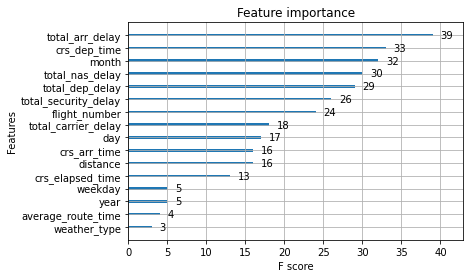

In [48]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Linear Regression

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  40.89496066568577
Model R2 Score is:  0.07881136015159595


##### Ridge/Lasso Regression

In [54]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  40.8949612549574
Model R2 Score is:  0.07881133360405412
Model RMSE is:  41.01801140923767
Model R2 Score is:  0.0732594054996556


In [55]:
df_flight_info.corr(method='pearson')

,op_carrier_fl_num,crs_dep_time,dep_time,dep_delay,arr_time,arr_delay,crs_arr_time,crs_elapsed_time,actual_elapsed_time,distance,...,weekday,weather_type,flight_number,total_security_delay,total_nas_delay,average_route_time,total_dep_delay,total_arr_delay,total_weather_delay,total_carrier_delay
op_carrier_fl_num,1.000000,0.057545,0.062576,0.007600,0.057392,0.021479,0.058226,-0.377214,-0.369898,-0.393939,...,0.042390,0.016474,0.304351,-0.025858,-0.096552,-0.445532,0.027916,0.077998,0.078097,0.325990
crs_dep_time,0.057545,1.000000,0.949764,0.108764,0.514153,0.101913,0.616450,-0.094680,-0.094846,-0.085649,...,-0.000090,-0.000039,0.012567,-0.005409,0.062272,-0.074196,0.220893,0.203820,0.020524,-0.000241
dep_time,0.062576,0.949764,1.000000,0.135860,0.541078,0.130458,0.620421,-0.096221,-0.094514,-0.089822,...,-0.002312,0.000869,0.014633,-0.005504,0.068630,-0.078775,0.225880,0.210559,0.024628,0.003183
dep_delay,0.007600,0.108764,0.135860,1.000000,-0.020282,0.945236,0.088733,0.008833,0.015245,0.004685,...,-0.013726,0.007074,0.006081,-0.006591,0.101764,0.004158,0.272252,0.252470,0.010054,0.059425
arr_time,0.057392,0.514153,0.541078,-0.020282,1.000000,-0.015866,0.801461,-0.027163,-0.025527,-0.032743,...,0.006634,0.001721,0.012143,-0.009070,0.080878,-0.029926,0.130255,0.127744,0.023974,-0.001885
arr_delay,0.021479,0.101913,0.130458,0.945236,-0.015866,1.000000,0.085556,-0.025854,0.041832,-0.025387,...,-0.023647,0.009135,0.006178,-0.009494,0.129038,-0.014373,0.255364,0.275374,0.021079,0.069489
crs_arr_time,0.058226,0.616450,0.620421,0.088733,0.801461,0.085556,1.000000,-0.028859,-0.027482,-0.033482,...,0.004090,0.002501,0.018468,-0.012262,0.098894,-0.031326,0.178633,0.170787,0.027915,0.000104
crs_elapsed_time,-0.377214,-0.094680,-0.096221,0.008833,-0.027163,-0.025854,-0.028859,1.000000,0.981415,0.982751,...,0.014380,-0.018640,-0.126807,0.007458,0.099726,0.838636,0.011629,-0.066130,-0.095501,-0.097866
actual_elapsed_time,-0.369898,-0.094846,-0.094514,0.015245,-0.025527,0.041832,-0.027482,0.981415,1.000000,0.968014,...,0.008146,-0.017253,-0.126816,0.005570,0.119771,0.830238,0.012679,-0.043334,-0.088965,-0.090061
distance,-0.393939,-0.085649,-0.089822,0.004685,-0.032743,-0.025387,-0.033482,0.982751,0.968014,1.000000,...,0.017706,-0.031220,-0.116870,0.022027,0.080994,0.834216,0.004243,-0.071163,-0.118345,-0.108987


##### Random Forest

In [ ]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [ ]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))